# Troubleshoot nmf._iterate_nb_theta()

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import nbinom
from scipy.special import digamma, polygamma
import seaborn as sns

In [24]:
sns.set()
%matplotlib inline

## Helper functions

In [77]:
def score(X, r, mu):
    elems = np.prod(X.shape)
    score = (elems * (-digamma(r) + np.log(r) + 1)
             + np.sum(digamma(X + r) - np.log(mu + r) - (X + r) / (mu + r)))
    return score

def trigamma(x):
    return polygamma(1, x)
    
def info(X, r, mu):
    elems = np.prod(X.shape)
    info = (elems * (-trigamma(r) + 1 / r)
            + np.sum(trigamma(X + r) - 2 / (mu + r) + (X + r) / ((mu + r)**2)))
    return info

def iterate_nb_theta(X, mu, r):
    """Use Newton's method to iterate negative binomial dispersion parameter.

    Args:
        X (numpy.ndarray): An array of counts.
        mu (numpy.ndarray): The expected value for each observed count in X.
        r (float): The current value of the negative binomial dispersion
            parameter.

    Returns:
        float: The next iterated value of r.
    """

    score = score(X, r, mu)
    info = info(X, r, mu)
    new_r = r - score / info
    return new_r

def mu_to_p(mu, r):
    p = 1 - mu / (r + mu)
    return p

In [50]:
def naive_r_estimator(X, mu):
    s2 = (X - mu)**2
    r_hat = np.mean((mu ** 2) / (s2 - mu))
    return r_hat

In [52]:
def nbinom_onestep_estimator(X, mu):
    numerator = np.sum(X.shape)
    denominator = np.sum((X / mu - 1) ** 2)
    return numerator / denominator

In [57]:
def fit_nbinom_r(X, mu, dof, reltol=0.001):
    """Fit the negative binomial dispersion parameter."""
    prev_r = nbinom_onestep_estimator(X, mu)
    iter = 0
    while True:
        iter += 1
        numerator = np.sum((X - mu)**2 / (mu + mu**2/prev_r)) - dof
        denominator = np.sum((X - mu)**2 / (mu + prev_r)**2)
        delta = numerator / denominator
        r = prev_r - delta
        if abs(r - prev_r) / prev_r < reltol:
            break
        prev_r = r
    return r, iter


def fit_nbinom_nmf_r(X, mu, k, reltol=0.001):
    """Fit the negative binomial NMF dispersion parameter."""
    free_params = np.prod(X.shape) - k * (np.sum(X.shape) - 1)
    r, iter = fit_nbinom_r(X, mu, free_params, reltol)
    return r, iter

## Create some test data and plot the functions.

In [16]:
r = 20
mu = 10
p = mu_to_p(mu, r)

In [17]:
x = nbinom.rvs(r, p, size=int(1e5))
x

array([ 3,  9, 12, ..., 12, 13,  9])

In [29]:
test_r = np.arange(10.1, 30.1, 0.1)
loglik_r = np.array([np.sum(nbinom.logpmf(x, rr, mu_to_p(mu, rr))) for rr in test_r])

In [34]:
score_r = np.array([score(x, rr, mu) for rr in test_r])

In [38]:
info_r = np.array([info(x, rr, mu) for rr in test_r])

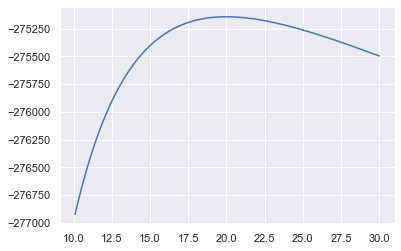

In [30]:
sns.lineplot(test_r, loglik_r)

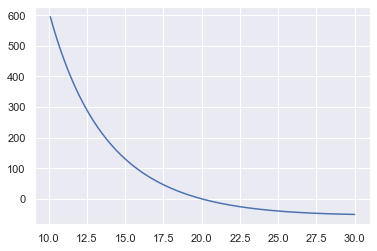

In [35]:
sns.lineplot(test_r, score_r)

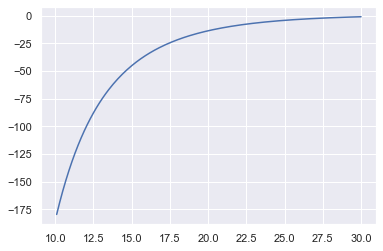

In [39]:
sns.lineplot(test_r, info_r)

### Test additional info values using very high and very low r

In [43]:
np.array([score(x, rr, mu) for rr in [1e-1, 1e-2, 1e-3, 1e-4]])

array([7.97579676e+05, 9.57814440e+06, 9.93232258e+07, 9.98832112e+08])

In [44]:
np.array([score(x, rr, mu) for rr in [1e2, 1e3, 1e4, 1e5]])

array([-1.64284948e+01, -2.41543943e-01, -2.50801262e-03, -2.51745514e-05])

In [41]:
np.array([info(x, rr, mu) for rr in [1e-1, 1e-2, 1e-3, 1e-4]])

array([-9.13739147e+06, -9.89868939e+08, -9.98711611e+10, -9.99610016e+12])

In [45]:
np.array([info(x, rr, mu) for rr in [30, 40, 50, 1e2, 1e3, 1e4, 1e5]])

array([-8.61010951e-01,  7.24695576e-01,  8.12023162e-01,  2.55938647e-01,
        4.72980191e-04,  5.00555848e-07,  5.03385247e-10])

## Test naive r estimator.

In [51]:
naive_r_estimator(x, mu)

-18.971457358222317

## Test method of moments.

In [53]:
nbinom_onestep_estimator(x, mu)

6.637453023426226

In [76]:
for rr in range(1, 31):
    pp = mu_to_p(mu, rr)
    y = scipy.stats.nbinom.rvs(rr, pp, size=int(1e5))
    r, iter = fit_nbinom_r(y, mu, len(y) - 1)

(1.003602069613119, 2)
(2.0062141341172914, 3)
(3.00901269323127, 3)
(3.9960002920746347, 3)
(5.001623679246264, 3)
(6.0319668019513335, 4)
(7.043361512433325, 4)
(7.979863591982983, 4)
(9.030739674380943, 4)
(9.999970995398778, 4)
(10.935666374728372, 4)
(12.016039902884433, 4)
(12.935611769308094, 4)
(13.990779577993544, 4)
(15.0208867928464, 4)
(15.960680456509582, 4)
(16.944171930411027, 4)
(17.988828926051383, 5)
(18.938302546834777, 5)
(19.902747119078974, 5)
(21.005791932335093, 5)
(21.655180746425394, 5)
(23.159726303841637, 5)
(23.92443411411357, 5)
(24.944927765703962, 5)
(26.10439991827595, 5)
(26.931553058227447, 5)
(28.225627850443125, 5)
(28.88909731985684, 5)
(29.817578487576423, 5)
